In [647]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import linear_regression
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler

# Part B: Mahalanobis distance

This noteook consists of theps required to run the PartB analysis. Overall goal is to compute individual per bundle distance of the preterm population to the population of controls. <br>
Steps:<br>

1. Read in the data, including the confounders to be adressed in the later analysis: selected in Part A, these are **age at scan, residual mean WM & foetal growth restriction. 
2. Scale **all metrics** to a range <0,1> so that they have the same weights during subsequent calculations 

We need to treat the preterm and control populations separately - this is because the distance should be calculated to the adjusted control population/correted variability - to remove the negative values => +/- residuals from the mean over all controls. <br>

1. compute residuals of bundle metrics (age at scan, residual WM, foetal growth restriction)
2. flatten the line by substracting/adding the residuals from the mean 

Only then compute the mahalanobis distance for:
1. preterms to corrected controls 
2. mean WM preterms to mean WM controls (for the corrections)

Afterwards, study the linear relationships of mahalanobis distance with age at birth (corrected for preterm confounders). 



In [648]:
def get_clinical_variables(iFile='../../DerivedData/Global.csv'):
    clinic = pd.read_csv(iFile, sep=';')
    
    #to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'ParenteralNutrition>21d', 'Pregnancy-size', 
    #      'Sex', 'Gabirth', 'PMA-MRI']
    
    to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'Gabirth', 'PMA-MRI']
    clinic = clinic[to_keep]
    clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'ParenteralNutrition>21d' : 'ParenteralNutrition',
                'Pregnancy-size' : 'PregnancySize', 
                'Gabirth' : 'birth_age',
                'PMA-MRI' : 'scan_age'
                }, inplace=True)
    
    ## correct excel commas in floats
    for col in ['birth_age', 'scan_age']:
        clinic[col] = clinic[col].astype(str)
        clinic[col] = clinic[col].apply(lambda x: x.replace(',','.'))
        clinic[col] = clinic[col].astype(np.float16)
        
    ### categorize what needs to be categorized

    #for col in ['ParenteralNutrition','PregnancySize', 'FetalGrowthRestriction', 'Sex']:
    for col in [ 'FetalGrowthRestriction']:
        clinic[col] = clinic[col].astype('category')
        clinic[col] = clinic[col].cat.codes
   
    return clinic


#def _get_residuals(global_WM, scan_age):
    
#    from pingouin import linear_regression
    
#    lm = linear_regression( X= scan_age, y = global_WM)
#    return lm.residuals_


def get_residuals(metric, df):
    from pingouin import linear_regression
    
    df = df.copy()
    
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['meanWM_' + metric] = np.float32(df['meanWM_' + metric].values)
    
    lm = linear_regression( X= df[['scan_age', 'birth_age']], y = df['meanWM_' + metric])
    #lm = linear_regression( X= df['scan_age'], y = df['meanWM_' + metric])
    return lm.residuals_


def _get_meanWM(group):
    
    # group must be either 'preterm' or 'control'
    ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
    mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

    WM = pd.concat([ex_WM, mod_WM])
    WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)

    cols = [col for col in WM.columns if group in col]
    cols = [col for col in cols if 'post' not in col]

    WM = WM[cols]
    WM = WM.set_axis(['meanWM_'+col.split('_')[1] for col in cols] , axis=1, inplace=False)
    WM.reset_index(drop=True, inplace=True)
    WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)
    
    
    return WM

def _scaleWM(df):
    
    df = df.copy()
    
    from sklearn.preprocessing import MinMaxScaler
    cols = [col for col in df.columns if 'meanWM' in col]
    
    for col in cols:
        scaler = MinMaxScaler(feature_range=(0, 1))
        df[col] = scaler.fit_transform(df[[col]])
        
    return df

def get_scaled_residual_meanWM(df, group, metrics = ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']):
    
    merged_df = pd.merge(df, _get_meanWM(group=group), how='inner', on=['subject_id'])
    
    merged_df = _scaleWM(df = merged_df)
    
    for metric in metrics: 
        #merged_df['residual_meanWM_'+metric ] = _get_residuals(global_WM = np.float32(merged_df['meanWM_' + metric].values), 
        #                                   scan_age = np.float32(merged_df['scan_age'].values))
    
        merged_df['residual_meanWM_'+metric ] = get_residuals(metric=metric, df=merged_df)
    return merged_df      


def scale_bundle_metrics(df, bundles, metrics):
    df = df.copy()
    for bundle in bundles:
        for metric in metrics:
            
            scaler = MinMaxScaler(feature_range=(0, 1))
            df[bundle+'_'+metric] = scaler.fit_transform(df[[bundle+'_'+metric]])
            
    return df

In [649]:
### the bundles of interest, fix the ordering for plots 
## to fix the ordering for plots 
pair_names = [
    'M1-Brainstem', 'S1-Brainstem','Paracentral-Brainstem',
    'M1-Caud', 'S1-Caud','Paracentral-Caud',
    'M1-Lenti', 'S1-Lenti','Paracentral-Lenti', 
    'M1-Thalfus', 'S1-Thalfus','Paracentral-Thalfus', 
    'M1L-M1R', 'S1L-S1R',
    'S1-M1' ]

metrics = ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']

#sets = [['AD','RD', 'FA', 'MD'], ['NDI', 'ODI']]
#set_names = ['set1', 'set2']

sets = [['AD','RD'], ['FA', 'MD'], ['NDI', 'ODI']]
set_names = ['set1', 'set2', 'set3']


In [650]:
## first deal with the control population (take only the matches!)
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

# the airing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]

#preterm_ids = preterms.subject_id.values
#control_ids = controls.subject_id.values

### scale diffusion metrics by minmaxing between 0,1
controls = scale_bundle_metrics(df=controls, bundles=pair_names, metrics=metrics)
preterms = scale_bundle_metrics(df=preterms, bundles=pair_names, metrics=metrics)

### get clinical variables 
controls = pd.merge(controls,  get_clinical_variables(), how='inner', on=['subject_id']) 
preterms = pd.merge(preterms,  get_clinical_variables(), how='inner', on=['subject_id']) 

### get scaled residual variables 
controls = get_scaled_residual_meanWM(controls, group='control')
preterms = get_scaled_residual_meanWM(preterms, group='preterm')

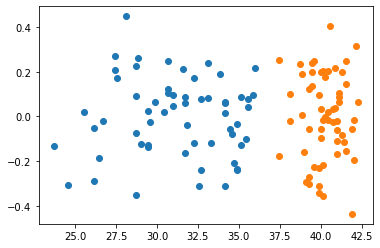

In [651]:
plt.scatter(preterms['birth_age'],preterms['residual_meanWM_AD'])
plt.scatter(controls['birth_age'],controls['residual_meanWM_AD'])
plt.show()

### So far
We have scaled the diffusion metric features, extracted clinical information and mean WM metrics, and after scaling those, computed the residual WM after the correction with age at scan. <br><br>

Next, we need to focus on the **control** group:
1. first compute new 'metric values' which will be adjusted for age at scan, residual_meanWM, and FoetalGrowthRestriction 

In [652]:
def correct_bundles(df, bundles, metrics):
    
    from pingouin import linear_regression
    
    df = df.copy()
    for bundle in bundles:
        for metric in metrics:
            bundle_metric = bundle+'_'+metric
            
            mean = np.mean(df[bundle_metric])
            correction = ['birth_age', 'scan_age', 'residual_meanWM_'+metric, 'FetalGrowthRestriction']
            #correction = ['birth_age', 'scan_age', 'FetalGrowthRestriction']
            
            lm = linear_regression( X= df[correction ],y = df[bundle_metric])
            
            ### not sure I should be doing this - scale instead? 
            df[bundle_metric] = lm.residuals_ + mean
            
            #scaler = MinMaxScaler(feature_range=(0, 1))
            #new = scaler.fit_transform(lm.residuals_.reshape(-1, 1))
            #df[bundle_metric] = new
            
    return df


## maybe I do not need this
"""
def correct_WM_controls(df, metrics):
    
    from pingouin import linear_regression
    
    df = df.copy()

    for metric in metrics:
        
            column_name = 'meanWM_'+metric
            
            mean = np.mean(df[column_name])
            #correction = ['birth_age', 'scan_age', 'residual_meanWM_'+metric, 'FetalGrowthRestriction']
            correction = ['birth_age', 'scan_age', 'FetalGrowthRestriction']
            
            lm = linear_regression( X= df[correction ],y = df[column_name])
            
            ### not sure I should be doing this - scale instead? 
            df[column_name] = lm.residuals_ + mean
            
            #scaler = MinMaxScaler(feature_range=(0, 1))
            #new = scaler.fit_transform(lm.residuals_.reshape(-1, 1))
            #df[bundle_metric] = new
            
    return df"""

"\ndef correct_WM_controls(df, metrics):\n    \n    from pingouin import linear_regression\n    \n    df = df.copy()\n\n    for metric in metrics:\n        \n            column_name = 'meanWM_'+metric\n            \n            mean = np.mean(df[column_name])\n            #correction = ['birth_age', 'scan_age', 'residual_meanWM_'+metric, 'FetalGrowthRestriction']\n            correction = ['birth_age', 'scan_age', 'FetalGrowthRestriction']\n            \n            lm = linear_regression( X= df[correction ],y = df[column_name])\n            \n            ### not sure I should be doing this - scale instead? \n            df[column_name] = lm.residuals_ + mean\n            \n            #scaler = MinMaxScaler(feature_range=(0, 1))\n            #new = scaler.fit_transform(lm.residuals_.reshape(-1, 1))\n            #df[bundle_metric] = new\n            \n    return df"

In [653]:
corrected_ctr = correct_bundles(df=controls, bundles = pair_names, metrics = metrics)
#corrected_ctr = correct_WM_controls(df=controls,metrics = metrics)


## Compute Mahalanobis & correct for cofounders - we have 3 sets of 2 metrics 

In [654]:
def get_mahalanobis_bundles(effect_group, control_group, bundles, sets, set_names):

    mah_results = pd.DataFrame()
    
    for bundle in bundles:
        for subset, name in zip(sets, set_names):
            features = np.array([bundle+'_'+metric for metric in subset])
           
            control_ar = control_group[features]
            ### normalize by mean 
            mean_control = np.mean(control_ar, axis=0)
            control_ar = (control_ar / mean_control)
            
            ## get inverse covariance matrix for the control group 
            corr = np.cov(control_ar.T)
            corrI = np.linalg.inv(corr)
            
            distances = []
            for i, preterm in enumerate(effect_group.subject_id.values):
                subj_vect = effect_group[effect_group.subject_id == preterm][features].values[0]
                subj_vect = (subj_vect / mean_control)# / range_control
                cont_vect = np.mean(control_ar, axis=0) 
                
                mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
                
                mah_results.loc[i,'subject_id'] = preterm
                mah_results.loc[i, bundle+'_mh_'+name] = mh
            
    return mah_results
    
def get_adjusted_mahalanobis_WM(effect_group, control_group, sets, set_names):

    mah_results = pd.DataFrame()
    
    for subset, name in zip(sets, set_names):
            features = np.array(['meanWM_'+metric for metric in subset])
           
            control_ar = control_group[features]
            ### normalize by mean 
            mean_control = np.mean(control_ar, axis=0)
            control_ar = (control_ar / mean_control)
            
            ## get inverse covariance matrix for the control group 
            corr = np.cov(control_ar.T)
            corrI = np.linalg.inv(corr)
            
            distances = []
            for i, preterm in enumerate(effect_group.subject_id.values):
                subj_vect = effect_group[effect_group.subject_id == preterm][features].values[0]
                subj_vect = (subj_vect / mean_control)# / range_control
                cont_vect = np.mean(control_ar, axis=0) 
                
                mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
                
                mah_results.loc[i,'subject_id'] = preterm
                mah_results.loc[i, 'meanWM_mh_'+name] = mh
            
    
    return mah_results 

def correct_mh_WM(effect_group, WM):
    
    WM = WM.copy()
    for  col in ['meanWM_mh_set1', 'meanWM_mh_set2', 'meanWM_mh_set3']:
        lm = linear_regression( X= effect_group[['scan_age', 'birth_age']],
                               y = WM[col])
        
        WM[col] = lm.residuals_
        
    return WM

def correct_mahalanobis_results(results, bundles, set_names):
    results = results.copy()
    for bundle in bundles:
        for name in set_names:
            
            bundle_metric = bundle+ '_mh_' + name
            correction = correction = ['scan_age', 'meanWM_mh_'+name, 'FetalGrowthRestriction']
            #correction = correction = ['scan_age', 'FetalGrowthRestriction']
            
            lm = linear_regression( y= results[bundle_metric],
                               X = results[correction])
            results[bundle_metric] = lm.residuals_ #+ np.mean(results[bundle_metric])
    
    return results
    

In [656]:
mh_results = get_mahalanobis_bundles(effect_group=corrected_ptr, control_group=corrected_ctr, bundles=pair_names, sets=sets, set_names=set_names)

mh_WM = get_mahalanobis_WM(effect_group=preterms, control_group=corrected_ctr, sets=sets, set_names=set_names)

# this should be done before the computation? 
#mh_WM = correct_mh_WM(effect_group=preterms, WM=mh_WM)

### merge required for linear regressions 

mh_results= pd.merge(mh_results, mh_WM, how='inner', on ='subject_id')
mh_results = pd.merge(mh_results, 
                       preterms[['subject_id', 'scan_age', 'birth_age', 'FetalGrowthRestriction']], 
                      how='inner', on ='subject_id' )

In [661]:
new_df =  pd.merge(mh_WM, preterms, how="inner", on=["subject_id"])

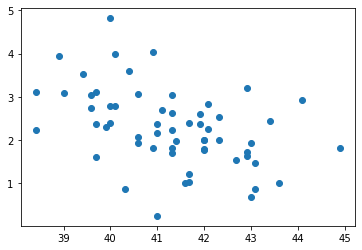

In [663]:
plt.scatter(new_df['scan_age'], new_df['meanWM_mh_set1'] )
plt.show()

In [673]:
new_df_WM_bundles  =  pd.merge(mh_WM, mh_results, how="inner", on=["subject_id"])

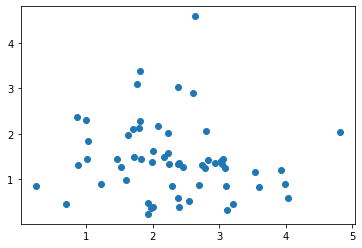

In [674]:
plt.scatter(mh_results['meanWM_mh_set1'], mh_results['M1-Brainstem_mh_set1'] )
plt.show()

In [639]:
mh_results_corrected = correct_mahalanobis_results(results = mh_results, bundles=pair_names, set_names=set_names)
#mh_results_corrected = mh_results.copy()

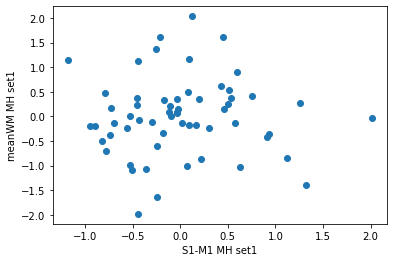

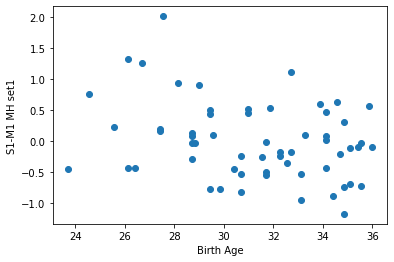

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.845072,0.775895,2.377992,0.020783,0.091105,0.075159,0.291369,3.398775
1,birth_age,-0.059072,0.024713,-2.390294,0.020162,0.091105,0.075159,-0.108560,-0.009585


In [640]:
plt.scatter(mh_results_corrected['S1-M1_mh_set1'], mh_results_corrected['meanWM_mh_set1'])
plt.xlabel('S1-M1 MH set1')
plt.ylabel('meanWM MH set1')
plt.show()

plt.scatter(mh_results_corrected['birth_age'], mh_results_corrected['S1-M1_mh_set1'])
plt.xlabel('Birth Age')
plt.ylabel('S1-M1 MH set1')
plt.show()

pg.linear_regression(y = mh_results_corrected['S1-M1_mh_set1'], X= mh_results_corrected['birth_age'])

In [641]:
#mh_results_corrected = mh_results_corrected[mh_results_corrected.birth_age <32]
#mh_results_corrected

## Compute linear regression with age 

In [642]:
### COMPUTE THE LINEAR REGRESSION WITH AGE 
results = pd.DataFrame()


for bundle in pair_names:
    for i, subset in enumerate(['set1', 'set2', 'set3']):
    #for i, subset in enumerate(['set1']):
        
        test= pg.linear_regression(X = mh_results_corrected['birth_age'], 
                                   y = mh_results_corrected[bundle+'_mh_'+subset])
        
        test2 = pg.linear_regression(X = mh_results_corrected['birth_age'], 
                                   y = mh_results_corrected[bundle+'_mh_'+subset], as_dataframe=False)

        results.loc[i, 'set'] = subset
        results.loc[i, bundle] = np.float64(test['pval'][1])
    #results_T.loc[i, new_col+'_T'] = np.round(np.float64(test['T'][1]),2)
    #results_T.loc[i, new_col+'_slope'] = np.float64(test['coef'][1])

        
results[results.columns[1:]] = results[results.columns[1:]].astype(np.float64)

pre_p = results[results.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(results[results.columns[1:]].values))

results[results.columns[1:]] = pvals_corr

In [643]:
mh_results_corrected

,subject_id,M1-Brainstem_mh_set1,M1-Brainstem_mh_set2,M1-Brainstem_mh_set3,S1-Brainstem_mh_set1,S1-Brainstem_mh_set2,S1-Brainstem_mh_set3,Paracentral-Brainstem_mh_set1,Paracentral-Brainstem_mh_set2,Paracentral-Brainstem_mh_set3,...,S1L-S1R_mh_set3,S1-M1_mh_set1,S1-M1_mh_set2,S1-M1_mh_set3,meanWM_mh_set1,meanWM_mh_set2,meanWM_mh_set3,scan_age,birth_age,FetalGrowthRestriction
0,CC00830XX14,-0.001217,-0.045077,-0.586108,0.891725,0.593901,0.488596,0.403075,0.200736,-0.088439,...,-0.161483,-0.458996,-0.548758,-0.561552,0.233588,-0.184984,0.762340,39.59375,30.437500,0
1,CC00136AN13,0.702245,0.645553,0.204309,0.499280,0.157556,0.216762,0.449572,0.540934,-0.199590,...,-0.482754,0.516043,0.402308,-0.241498,0.538040,0.449745,-0.417083,44.90625,31.000000,1
2,CC00418AN14,-0.025183,0.018309,0.046533,-0.157154,-0.289815,-0.526401,-0.467670,-0.490970,-0.133756,...,-0.814691,-0.103315,-0.477267,-0.792044,0.205756,-0.262342,1.031759,39.59375,36.000000,0
3,CC00804XX12,-0.438070,-0.591542,-1.553932,-0.923279,-0.867925,-0.921157,-0.084617,-0.278016,-1.218202,...,0.136445,0.082344,0.128593,-0.368567,0.503443,-0.081072,0.328218,39.68750,34.125000,1
4,CC00648XX22,-0.060109,-0.337167,-0.662780,0.168229,-0.025753,0.164120,-0.253635,-0.400175,0.545262,...,1.300310,-0.216223,0.164199,0.915692,1.617982,1.746756,0.777694,44.09375,34.718750,1
5,CC00855XX14,-0.195367,0.177988,-0.802789,-1.168874,-0.455862,-0.972703,-0.592050,0.270624,-0.511679,...,-0.169119,-0.775458,-0.821518,-0.386281,-0.697547,-0.733484,-0.004282,43.59375,29.859375,0
6,CC00838XX22,-1.000522,-1.054430,-0.794822,0.106369,0.015602,-0.210805,-0.352115,-0.510634,-0.750571,...,-0.507153,-0.555966,-0.697811,-0.839988,-0.233300,-0.487447,0.045729,40.00000,31.703125,0
7,CC00997BN25,-0.255126,-0.264742,-0.284323,0.821874,0.681920,-0.151922,0.509830,0.316109,0.449477,...,1.151813,-0.452406,-0.834397,0.215871,0.379990,0.876928,-0.628050,43.40625,23.703125,0
8,CC00301XX04,0.874217,0.711417,-0.274741,0.221683,0.498538,-0.792994,0.240088,-0.239868,-0.390479,...,-0.651064,0.121460,-0.176594,-0.801338,2.036435,1.307734,-0.483178,40.00000,28.703125,1
9,CC00632XX14,0.755897,0.734393,0.812079,1.049112,1.151525,1.018776,0.099583,0.088089,-0.215542,...,-0.441673,1.117972,1.148621,0.005111,-0.837360,-0.945578,-0.115132,43.09375,32.718750,0


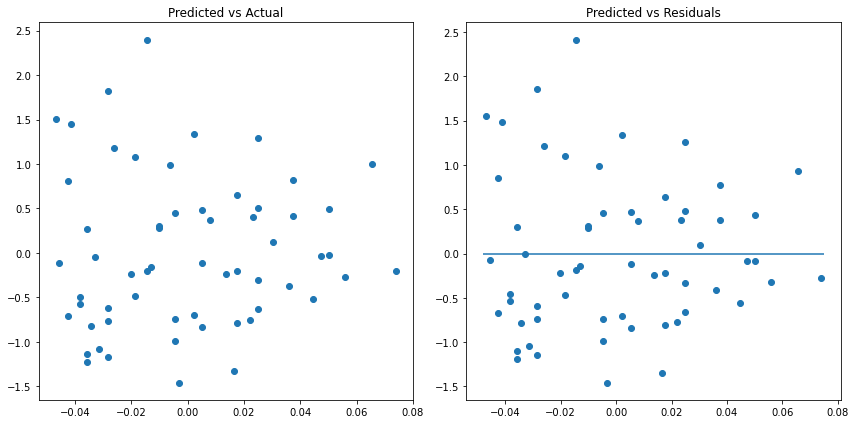

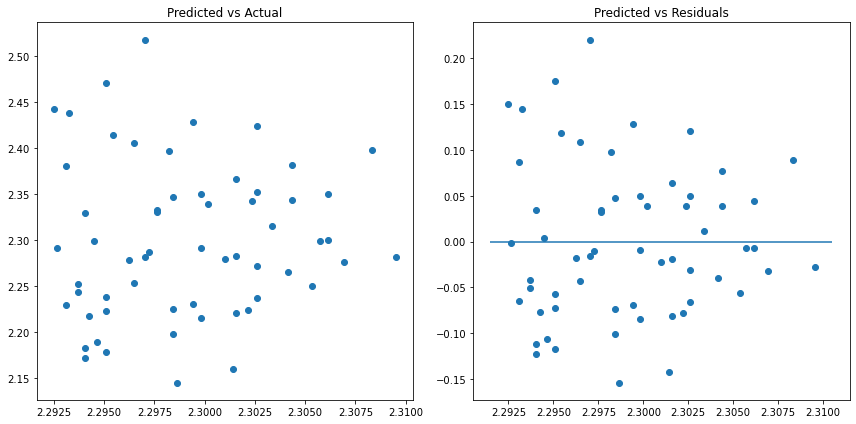

In [644]:

bundle = 'M1-Caud_mh_set3'
new_y = np.log(mh_results_corrected[bundle] +10)


test2 = pg.linear_regression(X = mh_results_corrected['birth_age'], 
                                   y = mh_results_corrected[bundle], as_dataframe=False)

test1 = pg.linear_regression(X = mh_results_corrected['birth_age'],
                            y = new_y, as_dataframe=False)


fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].scatter(test2['pred'], test2['y'])
axs[0].set_title('Predicted vs Actual')

axs[1].scatter(test2['pred'], test2['residuals'])
axs[1].set_title('Predicted vs Residuals')
axs[1].hlines(y=0, xmin=np.min(test2['pred'])-0.001, xmax=np.max(test2['pred'])+0.001)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].scatter(test1['pred'], test1['y'])
axs[0].set_title('Predicted vs Actual')

axs[1].scatter(test1['pred'], test1['residuals'])
axs[1].set_title('Predicted vs Residuals')
axs[1].hlines(y=0, xmin=np.min(test1['pred'])-0.001, xmax=np.max(test1['pred'])+0.001)
plt.tight_layout()
plt.show()
#plt.scatter( df['birth_age'], df['S1L-S1R_AD'])

In [645]:
colors = {'Brainstem' : 'forestgreen',
          'Caud' : 'darkmagenta', 
          'Lenti': 'blue', 
         'Thalfus': 'gray', 
          'M1R' : 'magenta', 
          'S1R' : 'magenta',
          'M1': 'teal',
         'S1': 'teal'}

In [646]:
results

,set,M1-Brainstem,S1-Brainstem,Paracentral-Brainstem,M1-Caud,S1-Caud,Paracentral-Caud,M1-Lenti,S1-Lenti,Paracentral-Lenti,M1-Thalfus,S1-Thalfus,Paracentral-Thalfus,M1L-M1R,S1L-S1R,S1-M1
0,set1,0.954865,0.954865,0.897611,0.917913,0.917913,0.917913,0.592829,0.891108,0.857348,0.709076,0.592829,0.926397,0.917913,0.592829,0.592829
1,set2,0.998597,0.970604,0.763537,0.891108,0.891108,0.917913,0.592829,0.903007,0.595305,0.592829,0.639299,0.917913,0.926397,0.592829,0.592829
2,set3,0.917913,0.954865,0.954865,0.926397,0.926397,0.926397,0.709076,0.603573,0.662315,0.891108,0.917913,0.917913,0.917913,0.891108,0.592829


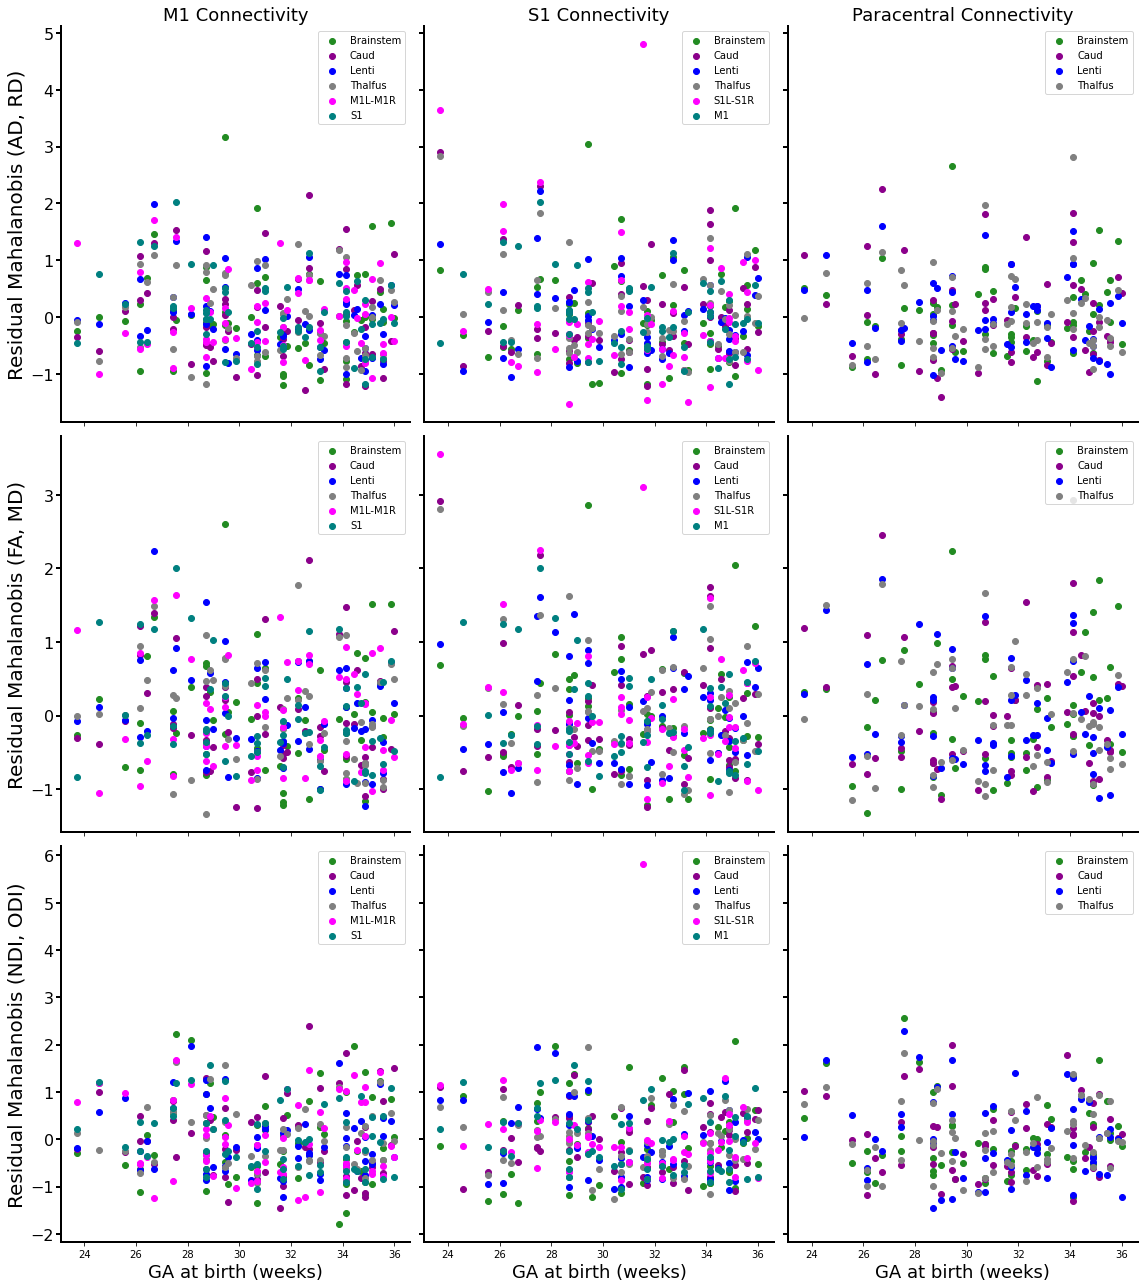

In [634]:
pairs = pair_names

fig, axs = plt.subplots(3,3, figsize=(16,18), sharex=True, sharey='row')


for i, subset in enumerate(['set1', 'set2', 'set3']):
    for pair in pairs: 
                        
        #print(name)
        

        if  pair in ['M1-Brainstem', 'M1-Caud', 'M1-Lenti', 'M1-Thalfus', 'M1L-M1R', 'S1-M1']:
            ax_idx = 0
            
            if pair == 'S1-M1':
                label = pair.split('-')[0]
            elif pair == 'M1L-M1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')    
        
            
        if pair in ['S1-Brainstem', 'S1-Caud', 'S1-Lenti', 'S1-Thalfus', 'S1L-S1R', 'S1-M1']: 
            ax_idx = 1
            
            if pair == 'S1L-S1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')  
                
        if pair in ['Paracentral-Brainstem', 'Paracentral-Caud', 'Paracentral-Lenti', 'Paracentral-Thalfus']: 
            ax_idx = 2
            label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')  

    
for i in range(3):
    axs[2,i].set_xlabel('GA at birth (weeks)', fontsize=18)
    
axs[0,0].set_title('M1 Connectivity', fontsize=18)
axs[0,1].set_title('S1 Connectivity', fontsize=18)
axs[0,2].set_title('Paracentral Connectivity', fontsize=18)

axs[0,0].set_ylabel('Residual Mahalanobis (AD, RD)', fontsize=20)
axs[1,0].set_ylabel('Residual Mahalanobis (FA, MD)', fontsize=20)
axs[2,0].set_ylabel('Residual Mahalanobis (NDI, ODI)', fontsize=20)

fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(3):
    for j in range(3):
        # Hide the right and top spines
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i,j].spines[axis].set_linewidth(2)
        
        axs[i,j].tick_params(axis='y', labelsize=16)    
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()

In [635]:
### COMPUTE THE LINEAR REGRESSION WITH AGE 
results = pd.DataFrame()

mh_results_corrected = mh_results_corrected[mh_results_corrected['birth_age'] < 32]


for bundle in pair_names:
    for i, subset in enumerate(['set1', 'set2', 'set3']):
    #for i, subset in enumerate(['set1']):
        
        test= pg.linear_regression(X = mh_results_corrected['birth_age'], 
                                   y = mh_results_corrected[bundle+'_mh_'+subset])
        
        test2 = pg.linear_regression(X = mh_results_corrected['birth_age'], 
                                   y = mh_results_corrected[bundle+'_mh_'+subset], as_dataframe=False)

        results.loc[i, 'set'] = subset
        results.loc[i, bundle] = np.float64(test['pval'][1])
    #results_T.loc[i, new_col+'_T'] = np.round(np.float64(test['T'][1]),2)
    #results_T.loc[i, new_col+'_slope'] = np.float64(test['coef'][1])

        
results[results.columns[1:]] = results[results.columns[1:]].astype(np.float64)

pre_p = results[results.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(results[results.columns[1:]].values))

results[results.columns[1:]] = pvals_corr

In [636]:
results

,set,M1-Brainstem,S1-Brainstem,Paracentral-Brainstem,M1-Caud,S1-Caud,Paracentral-Caud,M1-Lenti,S1-Lenti,Paracentral-Lenti,M1-Thalfus,S1-Thalfus,Paracentral-Thalfus,M1L-M1R,S1L-S1R,S1-M1
0,set1,0.723822,0.998938,0.998938,0.611561,0.510602,0.611561,0.554527,0.611561,0.743721,0.952171,0.281335,0.998938,0.611561,0.611561,0.510602
1,set2,0.611561,0.998938,0.998938,0.510602,0.554527,0.554527,0.510602,0.611561,0.510602,0.611561,0.351253,0.937278,0.933222,0.510602,0.510602
2,set3,0.611561,0.998938,0.510602,0.611561,0.611561,0.510602,0.510602,0.421661,0.554527,0.613317,0.558777,0.554527,0.510602,0.976024,0.510602


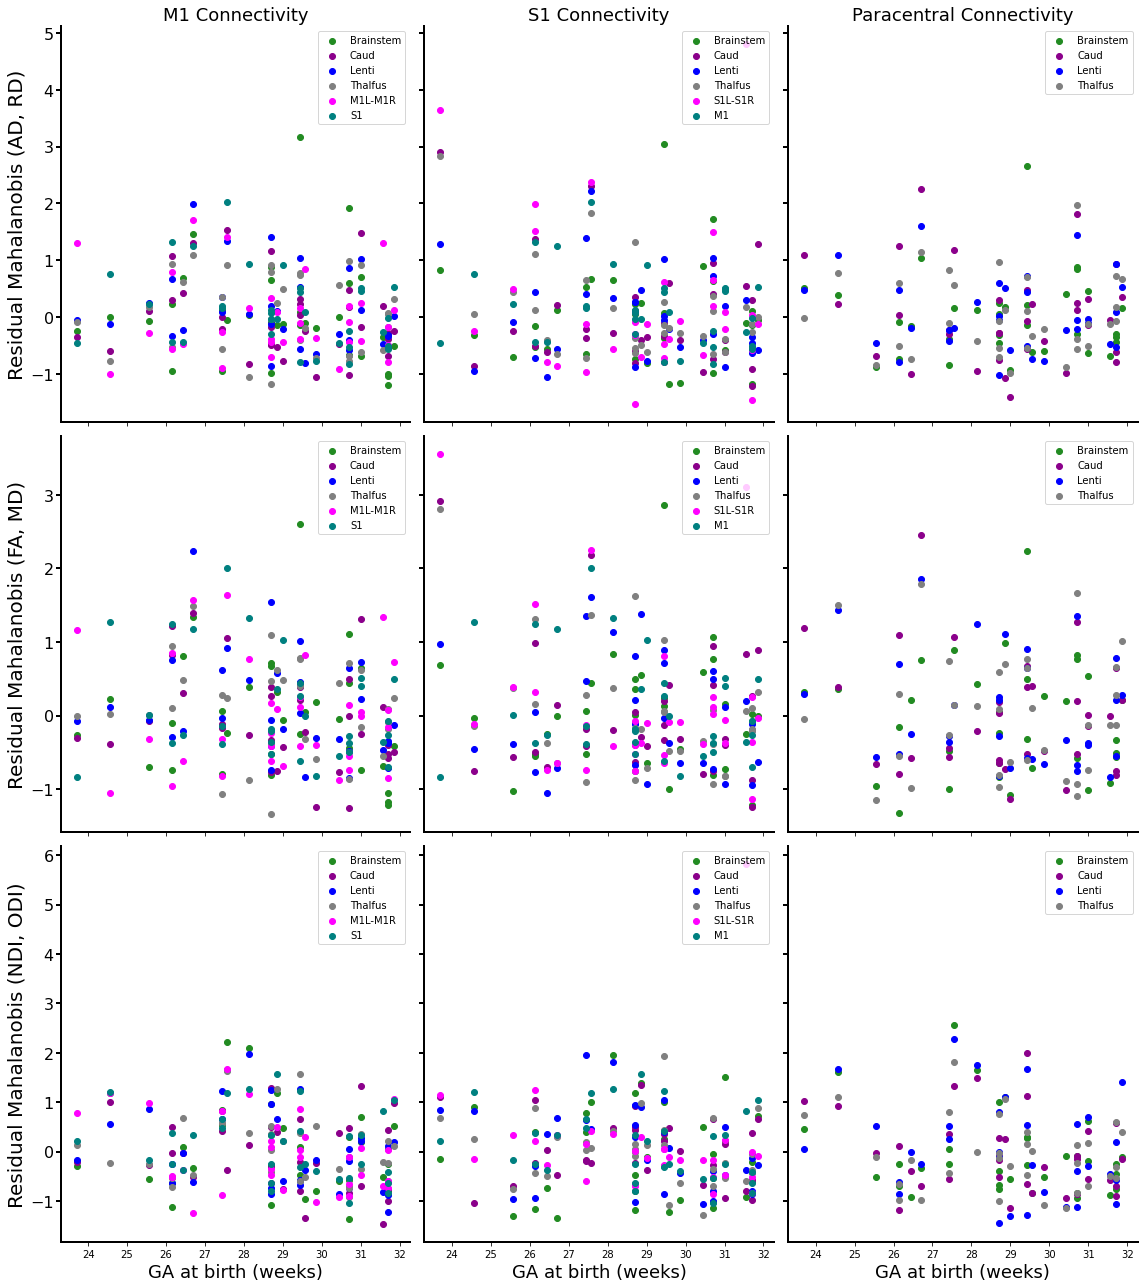

In [637]:
pairs = pair_names

fig, axs = plt.subplots(3,3, figsize=(16,18), sharex=True, sharey='row')


for i, subset in enumerate(['set1', 'set2', 'set3']):
    for pair in pairs: 
                        
        #print(name)
        

        if  pair in ['M1-Brainstem', 'M1-Caud', 'M1-Lenti', 'M1-Thalfus', 'M1L-M1R', 'S1-M1']:
            ax_idx = 0
            
            if pair == 'S1-M1':
                label = pair.split('-')[0]
            elif pair == 'M1L-M1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')    
        
            
        if pair in ['S1-Brainstem', 'S1-Caud', 'S1-Lenti', 'S1-Thalfus', 'S1L-S1R', 'S1-M1']: 
            ax_idx = 1
            
            if pair == 'S1L-S1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')  
                
        if pair in ['Paracentral-Brainstem', 'Paracentral-Caud', 'Paracentral-Lenti', 'Paracentral-Thalfus']: 
            ax_idx = 2
            label = pair.split('-')[1]
            
            axs[i,ax_idx].scatter( mh_results_corrected['birth_age'].values, mh_results_corrected[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        
        axs[i,ax_idx].legend(loc='upper right')  

    
for i in range(3):
    axs[2,i].set_xlabel('GA at birth (weeks)', fontsize=18)
    
axs[0,0].set_title('M1 Connectivity', fontsize=18)
axs[0,1].set_title('S1 Connectivity', fontsize=18)
axs[0,2].set_title('Paracentral Connectivity', fontsize=18)

axs[0,0].set_ylabel('Residual Mahalanobis (AD, RD)', fontsize=20)
axs[1,0].set_ylabel('Residual Mahalanobis (FA, MD)', fontsize=20)
axs[2,0].set_ylabel('Residual Mahalanobis (NDI, ODI)', fontsize=20)

fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(3):
    for j in range(3):
        # Hide the right and top spines
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i,j].spines[axis].set_linewidth(2)
        
        axs[i,j].tick_params(axis='y', labelsize=16)    
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()